In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
!pip install torch torchvision matplotlib tqdm


In [ ]:

data = pd. read_csv("/content/drive/MyDrive/Neuro/combined_output.csv")

In [ ]:
data.head()

,index,pos x,pos y,ori,major axis len,minor axis len,wing l x,wing l y,wing r x,wing r y,...,fg area,img contrast,min fg dist,wing l ang,wing r ang,wing l len,wing r len,frame,fly,folder_index
0,0,25.049020,50.578431,1.444188,19.381449,6.904603,21.0,66.0,24.0,66.0,...,232.0,35.0,16.124516,0.130152,0.058690,15.944257,15.457206,0,0,0
1,1,25.049020,50.578431,1.444188,19.381449,6.904603,21.0,66.0,24.0,66.0,...,235.0,32.0,15.652476,0.130152,0.058690,15.944257,15.457206,1,0,0
2,2,25.077670,50.601942,1.447305,19.303972,6.987740,21.0,66.0,24.0,66.0,...,232.0,37.0,16.124516,0.135384,0.053618,15.928829,15.435724,2,0,0
3,3,25.179245,50.500000,1.430134,19.369139,7.188067,21.0,66.0,24.0,66.0,...,231.0,37.0,15.652476,0.122704,0.064728,16.053538,15.544794,3,0,0
4,4,25.142857,50.561905,1.439746,19.268549,7.130880,21.0,66.0,24.0,66.0,...,231.0,37.0,16.124516,0.131126,0.057157,15.984306,15.480339,4,0,0


In [ ]:
threshold = 2
train_df = data[data['folder_index'] <= threshold]
test_df = data[data['folder_index'] > threshold]

In [ ]:
len(next(iter(train_loader)))

2

In [ ]:
# import torch
# from torch.utils.data import Dataset

# class FlySingleStepDataset(Dataset):
#     def __init__(self, df):
#         self.samples = []

#         # Group data by individual fly/trajectory (folder_index)
#         grouped = df.groupby('folder_index')

#         for _, group in grouped:
#             group = group.sort_values('frame').reset_index(drop=True)
#             pos = group[['pos x', 'pos y']].values

#             # Normalize the position using per-group mean and std
#             mean = pos.mean(axis=0)
#             std = pos.std(axis=0) + 1e-8  # avoid division by zero
#             norm_pos = (pos - mean) / std

#             # Make input → target pairs
#             for i in range(len(norm_pos) - 1):
#                 self.samples.append((norm_pos[i], norm_pos[i + 1]))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         current_pos, next_pos = self.samples[idx]
#         return torch.tensor(current_pos, dtype=torch.float32), torch.tensor(next_pos, dtype=torch.float32)


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FlySingleStepDataset(Dataset):
    def __init__(self, df):
        self.samples = []

        # Group data by individual fly/trajectory (folder_index)
        grouped = df.groupby('folder_index')

        for _, group in grouped:
            group = group.sort_values('frame').reset_index(drop=True)
            pos = group[['pos x', 'pos y']].values

            # Replace NaNs with 0.0
            pos = np.nan_to_num(pos, nan=0.0)

            # Make input → target pairs
            for i in range(len(pos) - 1):
                self.samples.append((pos[i], pos[i + 1]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        current_pos, next_pos = self.samples[idx]
        return torch.tensor(current_pos, dtype=torch.float32), torch.tensor(next_pos, dtype=torch.float32)


In [ ]:
from torch.utils.data import DataLoader, random_split

def create_minimal_dataloaders(df, folder_threshold, batch_size=32, val_split=0.2):
    # Split by folder index
    train_df = df[df['folder_index'] <= folder_threshold]
    test_df = df[df['folder_index'] > folder_threshold]

    # Create full training dataset
    full_train_dataset = FlySingleStepDataset(train_df)
    test_dataset = FlySingleStepDataset(test_df)

    # Compute split sizes
    val_size = int(len(full_train_dataset) * val_split)
    train_size = len(full_train_dataset) - val_size

    # Split into train and val
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, full_train_dataset



In [ ]:
import pandas as pd

# Load your CSV
# df = pd.read_csv('fly_trajectory.csv')

# Create dataloaders
# train_loader, test_loader = create_minimal_dataloaders(data, folder_threshold=5, batch_size=64)
train_loader, val_loader, test_loader, train_dataset = create_minimal_dataloaders(data, folder_threshold=2, batch_size=64)

# Peek at a batch
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)   # [batch_size, 2]
    print("Target shape:", targets.shape) # [batch_size, 2]
    break


Input shape: torch.Size([64, 2])
Target shape: torch.Size([64, 2])


In [ ]:
next(iter(test_loader))

[tensor([[264.4171, 252.3029],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [262.9302, 254.2442],
         [261.0114, 256.6023],
         [  0.0000,   0.0000],
         [259.8436, 258.6034],
         [  0.0000,   0.0000],
         [257.9766, 260.2339],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [256.2667, 262.1000],
         [255.6271, 263.0396],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [255.2742, 264.4140],
         [  0.0000,   0.0000],
         [254.7184, 266.1264],
         [254.1058, 267.5027],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [253.5622, 268.7081],
         [252.6364, 270.4034],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [251.9837, 271.7283],
         [251.4011, 272.8517],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [251.2097, 273.3333],
         [250.3422, 274.4546],
         [  0.0000,   0.0000],
        

FORWARD ADDING NOISE

In [ ]:
import torch
import numpy as np

def get_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

T = 100
betas = get_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)


In [ ]:
import torch
import numpy as np

def get_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

T = 100
betas = get_beta_schedule(T)
# Move the noise schedule tensors to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
betas = betas.to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)


alphas_cumprod_prev = torch.cat([torch.tensor([1.], device=alphas.device), alphas_cumprod[:-1]])

sqrt_recip_alphas = torch.sqrt(1. / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def q_sample(x_start, t, noise=None):
    """
    Adds Gaussian noise to x_start (i.e., next_pos) using the forward diffusion process.

    Args:
        x_start: (B, 2) - original next position
        t: (B,) - timesteps
        noise: (B, 2) - optional, if you want to pass pre-sampled noise

    Returns:
        x_t: (B, 2) - noised version of x_start
        noise: (B, 2) - noise used (sampled from N(0, I) if not provided)
    """
    if noise is None:
        noise = torch.randn_like(x_start)  # Sample ε ~ N(0, I)

    # Fetch the correct scale factors for each sample in the batch
    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].to(x_start.device).unsqueeze(1) # This was causing the error
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(x_start.device).unsqueeze(1)

    # Diffusion equation: x_t = √α̅_t * x_0 + √(1 - α̅_t) * ε
    x_t = sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

    return x_t, noise

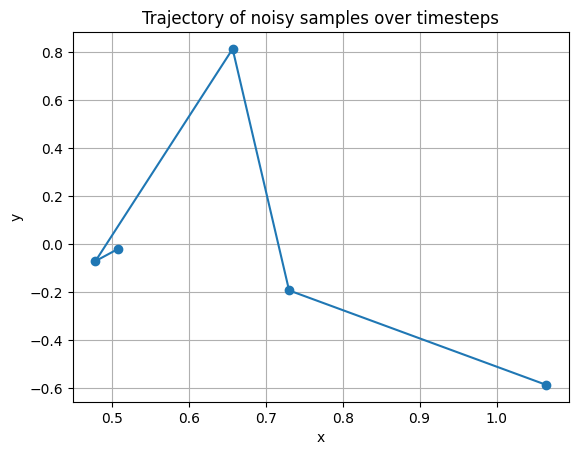

In [ ]:
import matplotlib.pyplot as plt

x0 = torch.tensor([[0.5, 0.0]])  # Some sample normalized position
# ts = torch.tensor([0, 200, 500, 800, 999]) # Original line causing error
ts = torch.tensor([0, 20, 50, 80, 99])  # Updated to be within the range of T
noised = []

for t_val in ts:
    x_t, _ = q_sample(x0, torch.tensor([t_val]))
    noised.append(x_t[0].numpy())

noised = np.array(noised)
plt.plot(noised[:, 0], noised[:, 1], 'o-')
plt.title("Trajectory of noisy samples over timesteps")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [ ]:
def p_sample(model, x_t, current_pos, t):
    """
    model: your trained denoising network
    x_t: current noisy input
    current_pos: known position (condition)
    t: current timestep

    returns: x_{t-1}, a less noisy sample
    """

    # Predict the noise ε
    pred_noise = model(x_t, current_pos, t)

    # Estimate x_0 from predicted noise
    x0_pred = (x_t - sqrt_one_minus_alphas_cumprod[t].unsqueeze(1) * pred_noise) / sqrt_alphas_cumprod[t].unsqueeze(1)

    # Compute mean of posterior q(x_{t-1} | x_t, x0)
    coef1 = betas[t] * torch.sqrt(alphas_cumprod_prev[t]) / (1. - alphas_cumprod[t])
    coef2 = (1. - alphas_cumprod_prev[t]) * torch.sqrt(alphas[t]) / (1. - alphas_cumprod[t])
    posterior_mean = coef1.unsqueeze(1) * x0_pred + coef2.unsqueeze(1) * x_t

    # Compute variance
    posterior_var = posterior_variance[t].unsqueeze(1)

    # Sample x_{t-1}
    if t[0] == 0:
        return posterior_mean  # last step: no noise
    noise = torch.randn_like(x_t)
    return posterior_mean + torch.sqrt(posterior_var) * noise


In [ ]:
import torch
import torch.nn as nn
import math

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: (B,) integer timesteps
        returns: (B, dim)
        """
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        emb = t.unsqueeze(1).float() * emb.unsqueeze(0)
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)


In [ ]:
import torch
import torch.nn as nn
import math

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim, device): # Add device argument
        super().__init__()
        self.dim = dim
        self.device = device # Store the device

    def forward(self, t):
        """
        t: (B,) integer timesteps
        returns: (B, dim)
        """
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=self.device) * -emb) # Create emb on the device
        emb = t.unsqueeze(1).float() * emb.unsqueeze(0)
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class DenoiseMLP(nn.Module):
    def __init__(self, time_embed_dim=16, hidden_dim=64, device='cuda'): # Add device argument
        super().__init__()
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim, device) # Pass device to SinusoidalTimeEmbedding

        self.model = nn.Sequential(
            nn.Linear(2 + 2 + time_embed_dim, hidden_dim),  # [x_t, current_pos, t_emb] a a*coeff
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Predict noise (same shape as input)
        )

    def forward(self, x_t, current_pos, t):
        """
        x_t: (B, 2) - noisy next_pos
        current_pos: (B, 2)
        t: (B,) - timestep
        """
        t_emb = self.time_embed(t)  # (B, time_embed_dim)
        x = torch.cat([x_t, current_pos, t_emb], dim=1)
        return self.model(x)  # (B, 2)

Notes - use sequences, history , p(next loc|history) each seq(image) ,  UNEt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_denoising_model(
    model, train_loader, val_loader, num_timesteps, device,
    epochs=100, lr=1e-3, patience=5
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for current_pos, next_pos in train_loader:
            current_pos = current_pos.to(device)
            next_pos = next_pos.to(device)


            B = current_pos.shape[0]
            t = torch.randint(0, num_timesteps, (B,), device=device)

            # forward
            x_t, noise = q_sample(next_pos, t)

            # predict
            pred_noise = model(x_t, current_pos, t)

            loss = loss_fn(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * B

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for current_pos, next_pos in val_loader:
                current_pos = current_pos.to(device)
                next_pos = next_pos.to(device)
                B = current_pos.shape[0]
                t = torch.randint(0, num_timesteps, (B,), device=device)
                x_t, noise = q_sample(next_pos, t)
                pred_noise = model(x_t, current_pos, t)
                val_loss = loss_fn(pred_noise, noise)
                total_val_loss += val_loss.item() * B

        avg_val_loss = total_val_loss / len(val_loader.dataset)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_denoise_model.pt")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training finished.")


In [ ]:
model = DenoiseMLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_denoising_model(model, train_loader, val_loader, num_timesteps=100, device=device)


[Epoch 1] Train Loss: 1.0271 | Val Loss: 0.9910
[Epoch 2] Train Loss: 0.9947 | Val Loss: 0.9958
[Epoch 3] Train Loss: 0.9934 | Val Loss: 0.9926
[Epoch 4] Train Loss: 0.9924 | Val Loss: 0.9911
[Epoch 5] Train Loss: 0.9937 | Val Loss: 0.9928
[Epoch 6] Train Loss: 0.9936 | Val Loss: 0.9937
Early stopping triggered.
Training finished.


TESTT

In [ ]:
model = DenoiseMLP()
model.load_state_dict(torch.load("best_denoise_model.pt"))
model.eval()
model.to(device)


DenoiseMLP(
  (time_embed): SinusoidalTimeEmbedding()
  (model): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
def predict_next_positions(model, test_loader, num_timesteps, device):
    model.eval()
    predictions = []
    ground_truth = []
    inputs = []

    with torch.no_grad():
        for current_pos, next_pos in test_loader:
            current_pos = current_pos.to(device)
            B = current_pos.shape[0]

            # Start from noise
            x_t = torch.randn_like(current_pos)

            for t in reversed(range(num_timesteps)):
                t_batch = torch.full((B,), t, device=device, dtype=torch.long)
                pred_noise = model(x_t, current_pos, t_batch)

                alpha = alphas[t]
                alpha_cumprod = alphas_cumprod[t]
                alpha_cumprod_prev = alphas_cumprod[t - 1] if t > 0 else torch.tensor(1.0, device=device)
                beta = betas[t]
                sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alpha_cumprod)

                x0_pred = (x_t - sqrt_one_minus_alpha_cumprod * pred_noise) / torch.sqrt(alpha_cumprod)

                coef1 = beta * torch.sqrt(alpha_cumprod_prev) / (1 - alpha_cumprod)
                coef2 = (1 - alpha_cumprod_prev) * torch.sqrt(alpha) / (1 - alpha_cumprod)
                posterior_mean = coef1 * x0_pred + coef2 * x_t

                if t > 0: # curr,[target x,y -> noise ->
                    noise = torch.randn_like(x_t)
                    posterior_var = posterior_variance[t]
                    x_t = posterior_mean + torch.sqrt(posterior_var) * noise
                else:
                    x_t = posterior_mean  # final prediction

            predictions.append(x_t.cpu())
            ground_truth.append(next_pos)
            inputs.append(current_pos.cpu())

    return torch.cat(inputs), torch.cat(predictions), torch.cat(ground_truth)


In [ ]:
# inputs, preds, targets = predict_next_positions(
#     model=model,
#     test_loader=test_loader,
#     num_timesteps=100,
#     device=device
# )


KeyboardInterrupt: 

Current:     (256.27, 262.10)
Predicted:   (-0.41, -0.99)
Ground truth:(489.83, 136.70)



<ipython-input-66-f84b4d25f33b>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


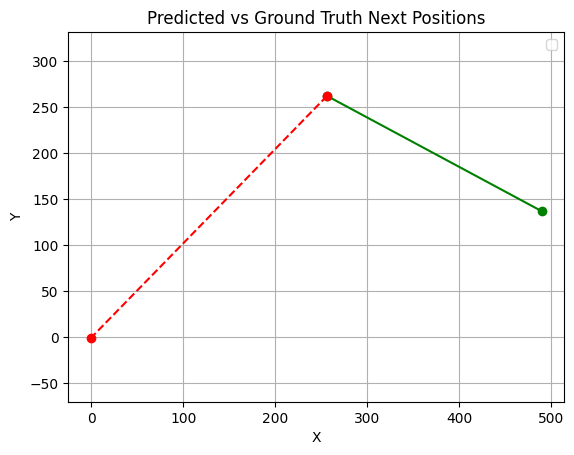

In [ ]:
import matplotlib.pyplot as plt

# Show a few predictions vs ground truth
for i in range(11,12):
    x, y = inputs[i]
    px, py = preds[i]
    tx, ty = targets[i]

    print(f"Current:     ({x:.2f}, {y:.2f})")
    print(f"Predicted:   ({px:.2f}, {py:.2f})")
    print(f"Ground truth:({tx:.2f}, {ty:.2f})\n")

    plt.plot([x, tx], [y, ty], 'go-', label='Ground Truth' if i == 0 else "")
    plt.plot([x, px], [y, py], 'ro--', label='Predicted' if i == 0 else "")

plt.legend()
plt.title("Predicted vs Ground Truth Next Positions")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis("equal")
plt.show()


In [ ]:
model.eval()
predictions = []
ground_truth = []
inputs = []

sample_count = 0
max_samples = 100

with torch.no_grad():
    for current_pos, next_pos in test_loader:
        current_pos = current_pos.to(device)
        B = current_pos.shape[0]

        if sample_count >= max_samples:
            break

        # Truncate if batch would push us over the limit
        if sample_count + B > max_samples:
            cutoff = max_samples - sample_count
            current_pos = current_pos[:cutoff]
            next_pos = next_pos[:cutoff]
            B = cutoff

        # Start from noise
        x_t = torch.randn_like(current_pos)

        for t in reversed(range(100)):
            t_batch = torch.full((B,), t, device=device, dtype=torch.long)
            pred_noise = model(x_t, current_pos, t_batch)

            alpha = alphas[t]
            alpha_cumprod = alphas_cumprod[t]
            alpha_cumprod_prev = alphas_cumprod[t - 1] if t > 0 else torch.tensor(1.0, device=device)
            beta = betas[t]
            sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alpha_cumprod)

            x0_pred = (x_t - sqrt_one_minus_alpha_cumprod * pred_noise) / torch.sqrt(alpha_cumprod)

            coef1 = beta * torch.sqrt(alpha_cumprod_prev) / (1 - alpha_cumprod)
            coef2 = (1 - alpha_cumprod_prev) * torch.sqrt(alpha) / (1 - alpha_cumprod)
            posterior_mean = coef1 * x0_pred + coef2 * x_t

            if t > 0:
                noise = torch.randn_like(x_t)
                posterior_var = posterior_variance[t]
                x_t = posterior_mean + torch.sqrt(posterior_var) * noise
            else:
                x_t = posterior_mean  # final prediction

        predictions.append(x_t.cpu())
        ground_truth.append(next_pos)
        inputs.append(current_pos.cpu())
        sample_count += B

# Concatenate results
inputs = torch.cat(inputs)
preds = torch.cat(predictions)
ground_truth = torch.cat(ground_truth)


EXTRAAAA


In [ ]:
def forward_diffusion_sample(x_start, t, noise=None):
    """
    Forward process: adds noise to the clean data x_start at timestep t.

    Args:
        x_start: (B, 2) - clean next_pos
        t: (B,) - timestep
        noise: optional Gaussian noise; sampled internally if None

    Returns:
        x_t: (B, 2) - noised version of x_start
        noise: (B, 2) - noise added
    """
    # print("start",x_start)
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].to(x_start.device).unsqueeze(1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(x_start.device).unsqueeze(1)

    x_t = sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise
    return x_t, noise


In [ ]:
def reverse_diffusion(model, current_pos, num_steps=1000):
    """
    Generate next_pos by denoising from x_T ~ N(0, I)

    Args:
        model: trained denoising model
        current_pos: (1, 2) - normalized current position (conditioning input)
        num_steps: number of timesteps to denoise through

    Returns:
        pred_next_pos: (1, 2) - predicted next_pos (normalized)
    """
    x_t = torch.randn_like(current_pos)  # Start from noise

    for t in reversed(range(num_steps)):
        t_batch = torch.full((1,), t, dtype=torch.long, device=current_pos.device)

        # Predict noise with model
        pred_noise = model(x_t, current_pos, t_batch)

        # Estimate x0
        x0_pred = (x_t - sqrt_one_minus_alphas_cumprod[t].to(x_t.device) * pred_noise) / sqrt_alphas_cumprod[t].to(x_t.device)

        # Compute mean of posterior q(x_{t-1} | x_t, x0)
        coef1 = betas[t] * torch.sqrt(alphas_cumprod_prev[t]) / (1. - alphas_cumprod[t])
        coef2 = (1. - alphas_cumprod_prev[t]) * torch.sqrt(alphas[t]) / (1. - alphas_cumprod[t])
        coef1 = coef1.to(x_t.device).unsqueeze(0)
        coef2 = coef2.to(x_t.device).unsqueeze(0)

        posterior_mean = coef1 * x0_pred + coef2 * x_t
        posterior_var = posterior_variance[t].to(x_t.device).unsqueeze(0)

        if t > 0:
            noise = torch.randn_like(x_t)
            x_t = posterior_mean + torch.sqrt(posterior_var) * noise
        else:
            x_t = posterior_mean  # final denoised result

    return x_t  # normalized next_pos


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_denoising_model(
    model, train_loader, val_loader, num_timesteps, device,
    epochs=100, lr=1e-3, patience=10
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for current_pos, next_pos in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            current_pos = current_pos.to(device)
            next_pos = next_pos.to(device)
            # print(current_pos,next_pos,"hjbf")
            # break

            B = current_pos.shape[0]
            t = torch.randint(0, num_timesteps, (B,), device=device)

            # Forward diffusion (add Gaussian noise)
            x_t, noise = forward_diffusion_sample(next_pos, t)


            # Predict noise
            pred_noise = model(x_t, current_pos, t)

            # --- NaN checks ---
            if torch.isnan(noise).any():
                print(" NaN detected in noise")
                print("Noise:", noise)
                break
            if torch.isnan(x_t).any():
                print(" NaN detected in x_t")
                print("x_t:", x_t)
                break
            if torch.isnan(pred_noise).any():
                print(" NaN detected in pred_noise")
                print("Predicted noise:", pred_noise)
                break

            # Loss computation
            loss = loss_fn(pred_noise, noise)

            if torch.isnan(loss):
                print(" NaN detected in loss")
                print("x_t:", x_t)
                print("t:", t)
                print("current_pos:", current_pos)
                break

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item() * B

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for current_pos, next_pos in val_loader:
                current_pos = current_pos.to(device)
                next_pos = next_pos.to(device)
                B = current_pos.shape[0]
                t = torch.randint(0, num_timesteps, (B,), device=device)
                x_t, noise = forward_diffusion_sample(next_pos, t)
                pred_noise = model(x_t, current_pos, t)
                val_loss = loss_fn(pred_noise, noise)
                total_val_loss += val_loss.item() * B

        avg_val_loss = total_val_loss / len(val_loader.dataset)

        print(f"→ Epoch {epoch+1} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # --- Early stopping ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_denoise_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered.")
                break

    print("✅ Training complete.")


In [ ]:
# Assuming you have these already loaded/prepared
# train_loader, val_loader = create_minimal_dataloaders(...)
# forward_diffusion_sample is defined
# sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, etc., are initialized

num_timesteps = 100  # Make sure this matches your noise schedule

train_denoising_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_timesteps=num_timesteps,
    device=device,
    epochs=100,
    lr=1e-3,
    patience=10
)


Epoch 1:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[105.8166, 311.5148],
        [252.7436,  75.1385],
        [ 36.8457, 367.9630],
        [359.7766, 243.1624],
        [347.0348, 328.4129],
        [201.5075, 272.1960],
        [269.6875, 265.4427],
        [490.8010, 136.7811],
        [294.5575, 306.6897],
        [ 50.4906,  66.3113],
        [255.0192, 202.7436],
        [382.8156, 306.6760],
        [290.7475, 236.1061],
        [368.3474, 298.0316],
        [379.8014, 295.6738],
        [536.5525, 318.3647],
        [135.9832,  82.7430],
        [384.1053, 360.3301],
        [297.3768, 322.6715],
        [376.5252, 288.7980],
        [128.8910, 113.6635],
        [286.7746, 171.5318],
        [362.9091, 331.7273],
        [387.3452, 164.2893],
        [410.2944, 245.2233],
        [303.4952, 254.3333],
        [494.9704,  67.9310],
        [ 91.4492, 154.6578],
        [527.6733, 312.7136],
        [189.8324, 370.9595],
        [480.0433, 207.8702],
        [267.9259, 345.0265],
        [419.8592, 383.8786],
        [3

→ Epoch 1 | Train Loss: 0.000000 | Val Loss: nan


Epoch 2:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[490.2620, 244.6898],
        [252.4400, 325.4000],
        [337.6467, 284.8802],
        [490.0102, 236.2500],
        [318.3971, 291.9167],
        [250.2206,  91.3186],
        [161.5344, 274.9365],
        [413.6562, 298.2396],
        [359.0333, 167.9500],
        [344.5934, 271.9011],
        [ 71.4041, 115.7565],
        [ 44.8364,  34.9636],
        [231.5026, 233.0576],
        [132.8267, 291.8960],
        [279.6042, 181.2188],
        [371.7514, 291.1271],
        [386.9775, 471.5730],
        [365.5388, 312.3886],
        [180.1739, 225.2228],
        [177.9837,  45.8859],
        [207.5879, 221.0905],
        [423.6721, 351.4044],
        [373.0439, 310.9506],
        [373.2896,  72.5246],
        [ 85.8319,  55.6460],
        [337.1786, 324.9184],
        [ 73.9307,  50.4752],
        [274.1316, 305.7210],
        [173.9430, 228.8860],
        [335.7071, 368.2929],
        [254.7737, 177.7579],
        [366.5846, 135.0769],
        [376.3495, 349.7957],
        [1

→ Epoch 2 | Train Loss: 0.000000 | Val Loss: nan


Epoch 3:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[156.1450, 331.7650],
        [170.6755, 260.7287],
        [268.4713, 189.5287],
        [221.6854, 464.9888],
        [397.1750, 322.9800],
        [ 98.5932, 118.8757],
        [ 76.7727,  73.5682],
        [335.2235, 235.8529],
        [363.4082, 282.1479],
        [134.6804, 251.4845],
        [372.3532,  96.6617],
        [197.9521, 298.5319],
        [  0.0000,   0.0000],
        [111.2250,  86.0917],
        [324.7526, 305.5722],
        [273.8853, 300.0601],
        [554.2158, 353.1105],
        [455.0000, 266.7725],
        [392.5800, 316.9000],
        [114.9182,  65.3727],
        [361.6461, 310.1538],
        [363.8861, 246.5693],
        [292.1290, 206.0516],
        [301.3822, 274.8639],
        [143.3542, 232.6146],
        [237.2857, 158.0571],
        [361.6890, 313.4146],
        [555.2579,  30.6226],
        [248.0429, 338.2857],
        [178.5026, 276.1762],
        [  0.0000,   0.0000],
        [355.4142, 301.5151],
        [269.9752, 251.5155],
        [1

Epoch 3:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 3 | Train Loss: 0.000000 | Val Loss: nan


Epoch 4:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[298.6416, 209.4335],
        [311.7408, 396.5079],
        [244.3386, 320.5503],
        [275.5093, 267.0621],
        [169.6599, 280.2893],
        [234.9319, 171.4555],
        [373.1493, 335.5274],
        [369.4555, 291.7749],
        [228.2892, 212.7990],
        [280.7556, 232.0389],
        [287.3394, 274.3697],
        [280.0435, 211.4402],
        [376.6632, 349.4974],
        [350.6120, 216.7322],
        [472.6276, 435.1633],
        [ 66.9256,  33.5950],
        [346.9628, 263.8670],
        [336.0818, 212.6604],
        [ 97.3214, 214.7398],
        [269.1050, 242.2486],
        [212.3333, 477.2083],
        [178.8585, 221.5519],
        [489.5288, 230.9424],
        [523.9774, 246.3785],
        [377.9948, 287.6546],
        [133.7202,  83.2280],
        [333.5872, 218.8023],
        [ 84.8415, 266.4153],
        [ 77.5167, 100.3778],
        [330.3069, 322.2574],
        [470.7720, 119.3472],
        [334.1337, 245.7965],
        [283.8136, 105.8983],
        [2

Epoch 4:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 4 | Train Loss: 0.000000 | Val Loss: nan


Epoch 5:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[364.9588, 312.0928],
        [ 87.1144, 457.1393],
        [119.6737,  93.0316],
        [364.2406, 230.3583],
        [162.3895, 237.0105],
        [318.5706, 293.8644],
        [299.1753, 166.0722],
        [506.7165, 332.2165],
        [363.1451, 196.9896],
        [281.9304, 231.3924],
        [298.0287, 285.7126],
        [251.4133, 209.2092],
        [338.9950, 242.7222],
        [490.9738, 138.5497],
        [ 59.9101,  54.6629],
        [381.9153, 252.1111],
        [170.1950, 201.8000],
        [125.8686, 435.6629],
        [489.7222, 136.7828],
        [503.0343, 240.6520],
        [102.4112,  59.2336],
        [298.5424, 283.2500],
        [ 75.8349,  51.0550],
        [230.6415, 201.5708],
        [ 35.0259,  36.5086],
        [290.9949, 351.6615],
        [349.4107, 239.2560],
        [  0.0000,   0.0000],
        [126.2709,  43.0936],
        [377.1640, 349.4127],
        [  0.0000,   0.0000],
        [390.1378, 409.7449],
        [320.8075, 284.7205],
        [1

Epoch 5:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 5 | Train Loss: 0.000000 | Val Loss: nan


Epoch 6:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[235.1483, 341.7418],
        [590.8301, 255.3349],
        [267.5638, 200.4734],
        [211.0150, 332.2000],
        [288.1337, 289.7384],
        [212.9728, 374.3696],
        [302.0000, 280.1465],
        [466.5668, 249.0428],
        [306.6914, 218.0571],
        [328.6349, 120.5661],
        [233.0660, 223.6041],
        [ 42.7658,  96.4504],
        [348.0739, 208.8523],
        [263.7200, 209.2400],
        [396.8806, 374.1692],
        [291.5419, 211.5475],
        [ 79.2857,  36.5625],
        [144.5505, 121.6919],
        [140.0101, 166.5381],
        [221.7260, 249.4423],
        [ 48.9669,  36.3223],
        [234.9211, 171.8053],
        [281.8421, 296.8421],
        [364.7747, 285.1319],
        [371.6389, 289.4167],
        [413.1946, 144.5892],
        [254.4251, 277.7923],
        [117.9529, 102.4974],
        [323.8244, 355.3658],
        [ 85.9279,  61.4234],
        [ 42.7400,  86.4000],
        [325.1495, 340.6340],
        [315.8546, 310.2364],
        [1

Epoch 6:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 6 | Train Loss: 0.000000 | Val Loss: nan


Epoch 7:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[356.1087, 255.7228],
        [379.2359, 346.5487],
        [392.3676, 286.9804],
        [124.2872, 289.8205],
        [279.6131, 300.6250],
        [306.0000, 310.6000],
        [417.6776, 393.8798],
        [329.8177, 264.4479],
        [401.0796, 182.5568],
        [292.2012, 214.8781],
        [ 67.9257, 218.9158],
        [  0.0000,   0.0000],
        [319.5050, 426.8650],
        [338.5278, 119.1204],
        [178.0619, 339.2577],
        [202.6343, 191.5943],
        [120.5502, 295.5024],
        [362.0513, 309.3641],
        [271.0314, 111.7592],
        [ 81.4545, 375.8075],
        [167.8579, 386.1218],
        [342.0155, 261.7887],
        [372.0874, 465.6120],
        [325.6444, 390.0111],
        [311.3351, 284.0000],
        [ 50.3462,  63.1346],
        [292.2986, 191.7149],
        [ 42.9604,  44.2871],
        [301.4192, 250.1465],
        [357.2513, 357.7990],
        [301.6343, 305.9543],
        [343.3883, 419.6505],
        [249.6961, 322.7157],
        [2

Epoch 7:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 7 | Train Loss: 0.000000 | Val Loss: nan


Epoch 8:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[ 51.7231, 267.0410],
        [495.2086, 394.8289],
        [222.5450, 317.3862],
        [146.3810, 372.5397],
        [361.7598, 310.3185],
        [410.7180, 342.5128],
        [346.3579, 272.0796],
        [316.8971, 440.1912],
        [174.0052, 141.6114],
        [392.7789, 317.0653],
        [252.0955, 349.6231],
        [355.2923, 301.2564],
        [238.1354, 239.6406],
        [140.1780, 166.9948],
        [196.7571, 239.9667],
        [268.6195, 192.0439],
        [174.7128, 232.2923],
        [265.6491, 251.5205],
        [359.4536, 302.1186],
        [218.6823, 333.4948],
        [267.9814, 250.6698],
        [348.7391, 269.6631],
        [476.6923, 419.1176],
        [250.7579, 307.4211],
        [ 38.9368, 424.8678],
        [129.9645, 164.3452],
        [358.2126, 343.9195],
        [ 50.7989, 220.3704],
        [236.6450, 108.0750],
        [248.2374, 335.6566],
        [289.4438, 328.9941],
        [255.3233, 249.9461],
        [ 27.7843,  66.0686],
        [3

→ Epoch 8 | Train Loss: 0.000000 | Val Loss: nan


Epoch 9:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[241.1546, 313.8358],
        [365.0929, 112.9180],
        [179.9086, 268.4946],
        [510.6588, 105.5308],
        [154.7598, 337.9461],
        [195.9762, 289.3036],
        [373.9175, 273.1068],
        [398.1457, 296.1256],
        [454.0846, 319.4776],
        [134.7211, 251.5263],
        [251.1202, 277.3510],
        [317.8644, 223.3277],
        [394.0500, 331.2700],
        [323.0843, 284.2640],
        [320.7514, 212.4162],
        [230.7846, 287.4410],
        [345.4745, 293.6224],
        [492.7330,  68.9424],
        [113.6753, 243.9639],
        [134.6378, 251.4898],
        [303.7586, 352.4384],
        [367.8201, 226.4709],
        [433.3935, 295.3518],
        [343.3947, 273.8737],
        [ 85.0791, 274.3446],
        [ 80.5111,  69.3111],
        [153.1832, 182.3508],
        [136.8307,  86.0529],
        [416.4576, 103.1186],
        [288.1302, 270.5266],
        [ 43.6632, 421.7053],
        [  0.0000,   0.0000],
        [529.8815, 210.1896],
        [2

Epoch 9:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 9 | Train Loss: 0.000000 | Val Loss: nan


Epoch 10:   0%|          | 0/32259 [00:00<?, ?it/s]

tensor([[257.9476, 249.9948],
        [419.7287, 396.3138],
        [394.4866, 293.9358],
        [474.5131, 434.6440],
        [260.2103, 290.6308],
        [139.7720, 312.4456],
        [ 46.1534, 216.8011],
        [344.7619, 165.2698],
        [347.8652, 261.4888],
        [358.3976, 196.2229],
        [220.8614, 216.4406],
        [436.1758, 340.5549],
        [328.2865, 228.0169],
        [172.1878, 283.7970],
        [344.6607, 198.3631],
        [554.4150, 374.3750],
        [223.5222, 128.6847],
        [398.0000, 296.2415],
        [288.8333, 279.0357],
        [102.8932,  86.0583],
        [271.5890, 261.7669],
        [198.1639, 194.0437],
        [363.8125, 404.6771],
        [133.7207, 449.2346],
        [172.6818, 227.1919],
        [225.0191, 271.1436],
        [335.8108, 210.6324],
        [378.3632, 287.2935],
        [ 79.2807,  35.5263],
        [227.6442, 216.8606],
        [320.7895, 239.8737],
        [267.4481, 251.5974],
        [102.7887, 191.7165],
        [1

Epoch 10:   0%|          | 0/32259 [00:00<?, ?it/s]


→ Epoch 10 | Train Loss: 0.000000 | Val Loss: nan
🛑 Early stopping triggered.
✅ Training complete.


In [ ]:
# print("t min:", T.min().item(), "t max:", T.max().item())
print("sqrt_alphas_cumprod shape:", sqrt_alphas_cumprod.shape)

# Create a sample t to demonstrate indexing
sample_t = torch.tensor([50])  # Example value within the valid range

print("sqrt_alphas_cumprod[sample_t]:", sqrt_alphas_cumprod[sample_t])
print("sqrt_one_minus_alphas_cumprod[sample_t]:", sqrt_one_minus_alphas_cumprod[sample_t])

# The following lines were problematic because 'x_start' and 'noise'
# were also not defined in this scope. They likely belonged to
# the 'forward_diffusion_sample' function.
#
# To demonstrate their usage, we'll need to create sample data:
x_start_example = torch.randn(1, 2)  # Example data for x_start
noise_example = torch.randn(1, 2)   # Example data for noise

print("x_start example:", x_start_example)
print("noise example:", noise_example)

sqrt_alphas_cumprod shape: torch.Size([100])
sqrt_alphas_cumprod[sample_t]: tensor([0.8771])
sqrt_one_minus_alphas_cumprod[sample_t]: tensor([0.4803])
x_start example: tensor([[-0.7379, -0.7019]])
noise example: tensor([[-0.3290, -0.5035]])


In [ ]:
for current_pos, next_pos in tqdm(train_loader, desc=f"Epoch {1+1}"):
            current_pos = current_pos.to(device)
            next_pos = next_pos.to(device)
            print("hjbf",current_pos,next_pos,"hjbf")
            break